In [1]:
import mne
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
import glob
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [2]:
_dfs_list = []
for csv_filename in tqdm(glob.glob('./data/*')):
    print(csv_filename)
    _dfs_list.append(pd.read_csv(csv_filename))
df = pd.concat(_dfs_list)
df

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

./data\2019-Nov.csv


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:55<00:00, 475.23s/it]


event_time event_type  product_id          category_id  \
0         2019-11-01 00:00:00 UTC       view     1003461  2053013555631882655   
1         2019-11-01 00:00:00 UTC       view     5000088  2053013566100866035   
2         2019-11-01 00:00:01 UTC       view    17302664  2053013553853497655   
3         2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
4         2019-11-01 00:00:01 UTC       view     1004775  2053013555631882655   
...                           ...        ...         ...                  ...   
67501974  2019-11-30 23:59:58 UTC       view    15700137  2053013559733912211   
67501975  2019-11-30 23:59:58 UTC       view    28719425  2053013565639492569   
67501976  2019-11-30 23:59:59 UTC       view     1004833  2053013555631882655   
67501977  2019-11-30 23:59:59 UTC       view     2701706  2053013563911439225   
67501978  2019-11-30 23:59:59 UTC       view     1004233  2053013555631882655   

                             category_code    brand    price    user_id  \
0                   electronics.smartphone   xiaomi   489.07  520088904   
1                appliances.sewing_machine   janome   293.65  530496790   
2                                      NaN    creed    28.31  561587266   
3                appliances.kitchen.washer       lg   712.87  518085591   
4                   electronics.smartphone   xiaomi   183.27  558856683   
...                                    ...      ...      ...        ...   
67501974                               NaN      NaN   277.74  532714000   
67501975                     apparel.shoes    baden    62.81  545223467   
67501976            electronics.smartphone  samsung   167.03  557794415   
67501977  appliances.kitchen.refrigerators  samsung   566.27  531607492   
67501978            electronics.smartphone    apple  1312.52  579969851   

                                  user_session  
0         4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  
1         8e5f4f83-366c-4f70-860e-ca7417414283  
2         755422e7-9040-477b-9bd2-6a6e8fd97387  
3         3bfb58cd-7892-48cc-8020-2f17e6de6e7f  
4         313628f1-68b8-460d-84f6-cec7a8796ef2  
...                                        ...  
67501974  02b4131c-0112-4231-aafa-ceaa08e77c1b  
67501975  734c5eef-0742-4f8b-9d22-48f75b0bc359  
67501976  6fecf566-ebb0-4e70-a243-cdc13ce044cb  
67501977  368ddc8b-5db9-40fb-b7ff-b6582a1192c0  
67501978  90aca71c-ed8a-4670-866a-761ebacb732d  

[67501979 rows x 9 columns]

In [3]:
df.head(5)

event_time event_type  product_id          category_id  \
0  2019-11-01 00:00:00 UTC       view     1003461  2053013555631882655   
1  2019-11-01 00:00:00 UTC       view     5000088  2053013566100866035   
2  2019-11-01 00:00:01 UTC       view    17302664  2053013553853497655   
3  2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
4  2019-11-01 00:00:01 UTC       view     1004775  2053013555631882655   

               category_code   brand   price    user_id  \
0     electronics.smartphone  xiaomi  489.07  520088904   
1  appliances.sewing_machine  janome  293.65  530496790   
2                        NaN   creed   28.31  561587266   
3  appliances.kitchen.washer      lg  712.87  518085591   
4     electronics.smartphone  xiaomi  183.27  558856683   

                           user_session  
0  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  
1  8e5f4f83-366c-4f70-860e-ca7417414283  
2  755422e7-9040-477b-9bd2-6a6e8fd97387  
3  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  
4  313628f1-68b8-460d-84f6-cec7a8796ef2

In [4]:
df=df.head(50000)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     50000 non-null  object 
 1   event_type     50000 non-null  object 
 2   product_id     50000 non-null  int64  
 3   category_id    50000 non-null  int64  
 4   category_code  32972 non-null  object 
 5   brand          41901 non-null  object 
 6   price          50000 non-null  float64
 7   user_id        50000 non-null  int64  
 8   user_session   50000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


In [6]:
df.describe()

product_id   category_id         price       user_id
count  5.000000e+04  5.000000e+04  50000.000000  5.000000e+04
mean   1.159684e+07  2.058135e+18    287.622573  5.353952e+08
std    1.237653e+07  2.012812e+16    354.206867  2.022713e+07
min    1.001588e+06  2.053014e+18      0.000000  2.752567e+08
25%    1.306569e+06  2.053014e+18     65.380000  5.158744e+08
50%    5.800863e+06  2.053014e+18    167.175000  5.312668e+08
75%    1.710004e+07  2.053014e+18    358.310000  5.548736e+08
max    6.050000e+07  2.180737e+18   2574.070000  5.663004e+08

In [7]:
df.count()

event_time       50000
event_type       50000
product_id       50000
category_id      50000
category_code    32972
brand            41901
price            50000
user_id          50000
user_session     50000
dtype: int64

In [8]:
num_users = df['user_id'].nunique()
num_products = df['product_id'].nunique()
num_categories = df['category_id'].nunique()
num_category_code = df['category_code'].nunique()
num_brands = df['brand'].nunique()
print('Total number of users: ',num_users)
print('Total number of products: ', num_products)
print('Total number of categories: ', num_categories)
print('Total number of taxonomies: ', num_category_code)
print('Total number of brands: ', num_brands)

Total number of users:  10538
Total number of products:  13570
Total number of categories:  521
Total number of taxonomies:  117
Total number of brands:  1294


In [9]:
df1=df
print("copy sucessfull")

copy sucessfull


In [10]:
numerical_feature= [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if df[feature].dtypes == 'int64']
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 4
Discrete feature Count 3
Continuous feature Count 1
Categorical feature Count 5


In [11]:
print("Numerical features:",numerical_feature)
print("discrete_features:",discrete_feature)
print("continuous_features:",continuous_feature)
print("categorical_features:",categorical_feature)

Numerical features: ['product_id', 'category_id', 'price', 'user_id']
discrete_features: ['product_id', 'category_id', 'user_id']
continuous_features: ['price']
categorical_features: ['event_time', 'event_type', 'category_code', 'brand', 'user_session']


In [12]:
#missing values
df1.isnull().sum()*100/len(df)

event_time        0.000
event_type        0.000
product_id        0.000
category_id       0.000
category_code    34.056
brand            16.198
price             0.000
user_id           0.000
user_session      0.000
dtype: float64

In [13]:
#handling missing values, with mode because of categorical data due to high probabilty
def mode_nan(df,variable):
    mode=df1[variable].value_counts().index[0]
    df1[variable].fillna(mode,inplace=True)
mode_nan(df1,"category_code")
mode_nan(df1,"brand")

C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\1361736030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[variable].fillna(mode,inplace=True)
C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\1361736030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[variable].fillna(mode,inplace=True)


In [14]:
#check missing values
df1.isnull().sum()*100/len(df)

event_time       0.0
event_type       0.0
product_id       0.0
category_id      0.0
category_code    0.0
brand            0.0
price            0.0
user_id          0.0
user_session     0.0
dtype: float64

In [15]:
#remove duplicates
df.drop_duplicates(inplace=True)

C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\1441324773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


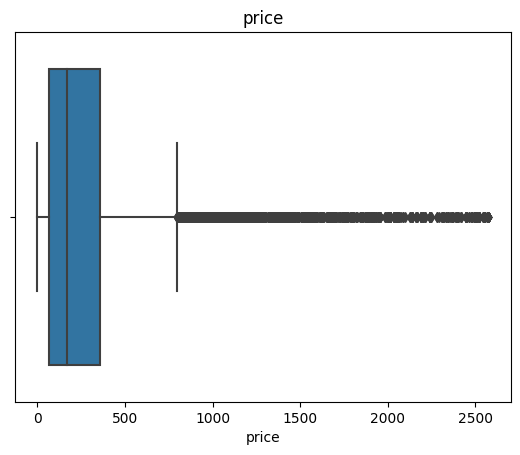

<Figure size 1500x1500 with 0 Axes>

In [16]:
for feature in continuous_feature:
    data=df1.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [17]:
def removeoutlier(df,variable):
    IQR=df[variable].quantile(0.75)-df[variable].quantile(0.25)
    lower_bridge=df[variable].quantile(0.25)-(IQR*1.5)
    upper_bridge=df[variable].quantile(0.75)+(IQR*1.5)
    print(lower_bridge, upper_bridge)
    df.loc[df[variable]>=upper_bridge,variable]=upper_bridge
    df.loc[df[variable]<=lower_bridge,variable]=lower_bridge

In [18]:
for feature in continuous_feature:
    print(feature)
    removeoutlier(df,feature)

price
-374.015 797.7049999999999


C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


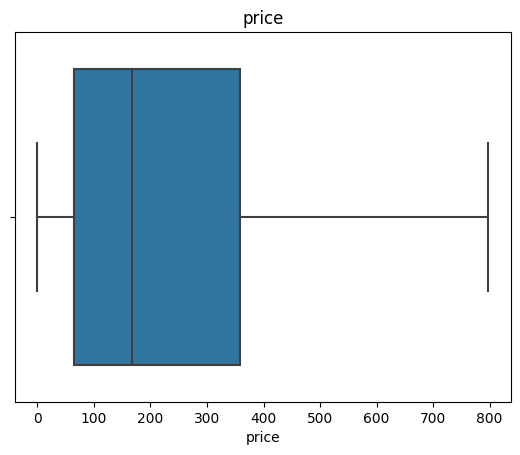

<Figure size 1500x1500 with 0 Axes>

In [19]:
for feature in continuous_feature:
    data=df1.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [20]:
# Calculate skewness for each numerical column
for i in continuous_feature:
    skewness = df[i].skew()
    # Print the skewness values
    print(i,skewness)

price 1.171425455019478


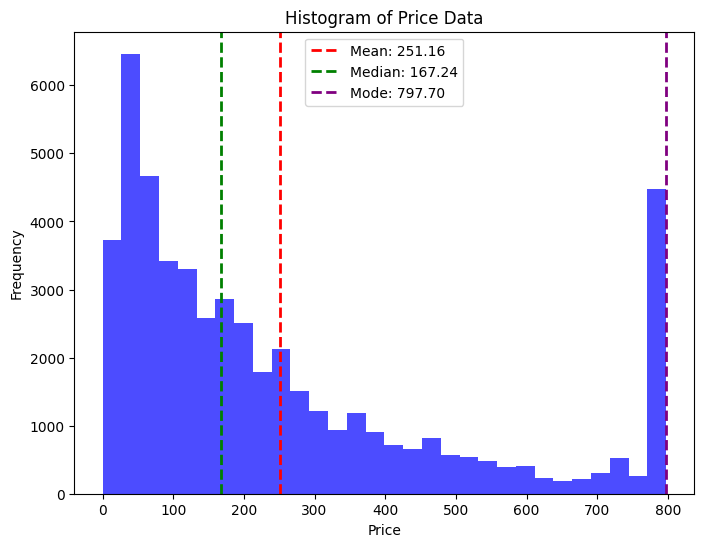

In [21]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the 'price' column
price_data = df['price']

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
plt.hist(price_data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Price Data')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Calculate mean, median, and mode
mean_price = price_data.mean()
median_price = price_data.median()
mode_price = price_data.mode().iloc[0]  # Handle multiple modes by taking the first one

# Add vertical lines for mean, median, and mode
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_price:.2f}')
plt.axvline(mode_price, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_price:.2f}')

# Add a legend
plt.legend()

plt.show()


In [22]:
# Use the optimal lambda value for the transformation
df['price'] = np.sqrt(df['price'])

C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\2032304696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = np.sqrt(df['price'])


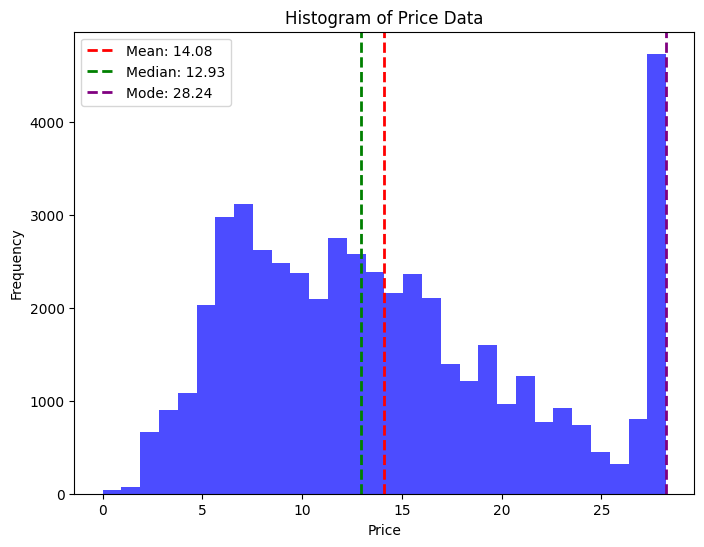

In [23]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the 'price' column
price_data = df['price']

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
plt.hist(price_data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Price Data')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Calculate mean, median, and mode
mean_price = price_data.mean()
median_price = price_data.median()
mode_price = price_data.mode().iloc[0]  # Handle multiple modes by taking the first one

# Add vertical lines for mean, median, and mode
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_price:.2f}')
plt.axvline(mode_price, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_price:.2f}')

# Add a legend
plt.legend()

plt.show()


In [24]:
#feature engineering
df[['main_category', 'sub_category']] = df['category_code'].str.split('.', n=1, expand=True)
print('Split successfully')


Split successfully


C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\4227071755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['main_category', 'sub_category']] = df['category_code'].str.split('.', n=1, expand=True)
C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\4227071755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['main_category', 'sub_category']] = df['category_code'].str.split('.', n=1, expand=True)


In [25]:
new_order = ['event_time', 'event_type', 'product_id', 'category_id', 'main_category', 'sub_category', 'brand', 'price', 'user_id', 'user_session']
df= df[new_order]
df.head(10)

event_time event_type  product_id          category_id  \
0  2019-11-01 00:00:00 UTC       view     1003461  2053013555631882655   
1  2019-11-01 00:00:00 UTC       view     5000088  2053013566100866035   
2  2019-11-01 00:00:01 UTC       view    17302664  2053013553853497655   
3  2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
4  2019-11-01 00:00:01 UTC       view     1004775  2053013555631882655   
5  2019-11-01 00:00:01 UTC       view     1306894  2053013558920217191   
6  2019-11-01 00:00:01 UTC       view     1306421  2053013558920217191   
7  2019-11-01 00:00:02 UTC       view    15900065  2053013558190408249   
8  2019-11-01 00:00:02 UTC       view    12708937  2053013553559896355   
9  2019-11-01 00:00:02 UTC       view     1004258  2053013555631882655   

  main_category    sub_category     brand      price    user_id  \
0   electronics      smartphone    xiaomi  22.114927  520088904   
1    appliances  sewing_machine    janome  17.136219  530496790   
2   electronics      smartphone     creed   5.320714  561587266   
3    appliances  kitchen.washer        lg  26.699625  518085591   
4   electronics      smartphone    xiaomi  13.537725  558856683   
5     computers        notebook        hp  18.976038  520772685   
6     computers        notebook        hp  22.683915  514028527   
7   electronics      smartphone   rondell   5.555178  518574284   
8   electronics      smartphone  michelin   8.527602  532364121   
9   electronics      smartphone     apple  27.056792  532647354   

                           user_session  
0  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  
1  8e5f4f83-366c-4f70-860e-ca7417414283  
2  755422e7-9040-477b-9bd2-6a6e8fd97387  
3  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  
4  313628f1-68b8-460d-84f6-cec7a8796ef2  
5  816a59f3-f5ae-4ccd-9b23-82aa8c23d33c  
6  df8184cc-3694-4549-8c8c-6b5171877376  
7  5e6ef132-4d7c-4730-8c7f-85aa4082588f  
8  0a899268-31eb-46de-898d-09b2da950b24  
9  d2d3d2c6-631d-489e-9fb5-06f340b85be0

In [26]:
# Convert 'event_date' to a pandas datetime object (if it's not already)
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract year, month, day, and time into separate columns
df['year'] = df['event_time'].dt.year
df['month'] = df['event_time'].dt.month
df['day'] = df['event_time'].dt.day
df['time'] = df['event_time'].dt.strftime('%H:%M:%S')  # Extract time as HH:MM:SS format
df['weekday'] = df['event_time'].dt.weekday
# If you want to drop the original 'event_date' column:
df.drop('event_time', axis=1, inplace=True)

# Display the resulting DataFrame
df.head(10)


C:\Users\Dedu\AppData\Local\Temp\ipykernel_11500\1719631642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_time'] = pd.to_datetime(df['event_time'])


event_type  product_id          category_id main_category    sub_category  \
0       view     1003461  2053013555631882655   electronics      smartphone   
1       view     5000088  2053013566100866035    appliances  sewing_machine   
2       view    17302664  2053013553853497655   electronics      smartphone   
3       view     3601530  2053013563810775923    appliances  kitchen.washer   
4       view     1004775  2053013555631882655   electronics      smartphone   
5       view     1306894  2053013558920217191     computers        notebook   
6       view     1306421  2053013558920217191     computers        notebook   
7       view    15900065  2053013558190408249   electronics      smartphone   
8       view    12708937  2053013553559896355   electronics      smartphone   
9       view     1004258  2053013555631882655   electronics      smartphone   

      brand      price    user_id                          user_session  year  \
0    xiaomi  22.114927  520088904  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  2019   
1    janome  17.136219  530496790  8e5f4f83-366c-4f70-860e-ca7417414283  2019   
2     creed   5.320714  561587266  755422e7-9040-477b-9bd2-6a6e8fd97387  2019   
3        lg  26.699625  518085591  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  2019   
4    xiaomi  13.537725  558856683  313628f1-68b8-460d-84f6-cec7a8796ef2  2019   
5        hp  18.976038  520772685  816a59f3-f5ae-4ccd-9b23-82aa8c23d33c  2019   
6        hp  22.683915  514028527  df8184cc-3694-4549-8c8c-6b5171877376  2019   
7   rondell   5.555178  518574284  5e6ef132-4d7c-4730-8c7f-85aa4082588f  2019   
8  michelin   8.527602  532364121  0a899268-31eb-46de-898d-09b2da950b24  2019   
9     apple  27.056792  532647354  d2d3d2c6-631d-489e-9fb5-06f340b85be0  2019   

   month  day      time  weekday  
0     11    1  00:00:00        4  
1     11    1  00:00:00        4  
2     11    1  00:00:01        4  
3     11    1  00:00:01        4  
4     11    1  00:00:01        4  
5     11    1  00:00:01        4  
6     11    1  00:00:01        4  
7     11    1  00:00:02        4  
8     11    1  00:00:02        4  
9     11    1  00:00:02        4

In [27]:
# Donut chart of main_category
mainCat_values = df.groupby('main_category')['product_id'].nunique().sort_values(ascending=False)
mainCat_names = mainCat_values.index
mainCat_values

main_category
electronics     8212
appliances      1502
apparel         1039
furniture        884
computers        818
construction     367
kids             241
auto             221
accessories      172
sport            103
country_yard       4
medicine           4
stationery         3
Name: product_id, dtype: int64

In [28]:
print('Number of main-categories: ', len(mainCat_names))
fig = px.pie(names=mainCat_names, values=mainCat_values, hole=0.3)
fig.update_layout({"title":{"text":"Main category distribution", "x":0.50}})
fig.show()

Number of main-categories:  13


In [29]:
# Donut chart of sub_category - top 10
subCat_values = df.groupby('sub_category')['product_id'].nunique().sort_values(ascending=False)
subCat_names = subCat_values.index
subCat_values

sub_category
smartphone                 6868
shoes                       529
clocks                      488
kitchen.refrigerators       292
notebook                    277
                           ... 
belt                          3
accessories.anti_freeze       2
peripherals.camera            2
tools.soldering               1
furniture.hammok              1
Name: product_id, Length: 117, dtype: int64

In [30]:
# Donut chart of sub_category - top 10
subCat_values = df['sub_category'].value_counts().sort_values(ascending=False)
top_10_values = subCat_values.head(10)
other_value = subCat_values[10:].sum()

# Create a DataFrame for the top 10 and "Other" category
top_10_df = pd.DataFrame({'sub_category': top_10_values.index, 'count': top_10_values.values})
other_df = pd.DataFrame({'sub_category': ['Other'], 'count': [other_value]})

# Concatenate the DataFrames
combined_df = pd.concat([top_10_df, other_df])

# Create the donut chart
fig = px.pie(combined_df, names='sub_category', values='count', hole=0.3)
fig.update_layout(title="Sub category distribution")
fig.show()

In [31]:
# Create data of main and sub categories with counts of products 
category_counts = df.drop_duplicates(subset='product_id').groupby(['main_category', 'sub_category']).size().reset_index(name='count')

# Treemap plot
fig = px.treemap(category_counts, path=[px.Constant("all"), 'main_category', 'sub_category'], values='count',
                  color='count', hover_data=['count'],
                  color_continuous_scale='YlGnBu',)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [32]:
df

event_type  product_id          category_id main_category  \
0           view     1003461  2053013555631882655   electronics   
1           view     5000088  2053013566100866035    appliances   
2           view    17302664  2053013553853497655   electronics   
3           view     3601530  2053013563810775923    appliances   
4           view     1004775  2053013555631882655   electronics   
...          ...         ...                  ...           ...   
49995       view    28713437  2053013565639492569       apparel   
49996       view    15800006  2053013560144954031   electronics   
49997       view    16800580  2053013558316237377     furniture   
49998       view     1004495  2053013555631882655   electronics   
49999       view     1004741  2053013555631882655   electronics   

         sub_category     brand      price    user_id  \
0          smartphone    xiaomi  22.114927  520088904   
1      sewing_machine    janome  17.136219  530496790   
2          smartphone     creed   5.320714  561587266   
3      kitchen.washer        lg  26.699625  518085591   
4          smartphone    xiaomi  13.537725  558856683   
...               ...       ...        ...        ...   
49995           shoes     baden   8.321058  542701491   
49996      smartphone   karcher  10.992270  516628722   
49997   kitchen.table  mebelson  12.111978  566295241   
49998      smartphone     meizu   8.321058  548899850   
49999      smartphone    xiaomi  13.782960  545590823   

                               user_session  year  month  day      time  \
0      4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  2019     11    1  00:00:00   
1      8e5f4f83-366c-4f70-860e-ca7417414283  2019     11    1  00:00:00   
2      755422e7-9040-477b-9bd2-6a6e8fd97387  2019     11    1  00:00:01   
3      3bfb58cd-7892-48cc-8020-2f17e6de6e7f  2019     11    1  00:00:01   
4      313628f1-68b8-460d-84f6-cec7a8796ef2  2019     11    1  00:00:01   
...                                     ...   ...    ...  ...       ...   
49995  566d4277-20d1-4364-9581-d28fbbea6609  2019     11    1  02:48:26   
49996  60138cee-2d9e-410f-a316-c8c1b3765a1d  2019     11    1  02:48:26   
49997  c375eab1-6be3-42ac-a58d-b32f9e4ad943  2019     11    1  02:48:26   
49998  ccf67200-ee46-4599-9c8f-2fe0902adc1b  2019     11    1  02:48:26   
49999  e73aa7a4-61fb-488d-a301-f4f3d4d8d885  2019     11    1  02:48:26   

       weekday  
0            4  
1            4  
2            4  
3            4  
4            4  
...        ...  
49995        4  
49996        4  
49997        4  
49998        4  
49999        4  

[49986 rows x 14 columns]

In [33]:
numerical_feature= [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if df[feature].dtypes == 'int64']
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 8
Discrete feature Count 3
Continuous feature Count 5
Categorical feature Count 6


In [34]:
print("Numerical features:",numerical_feature)
print("discrete_features:",discrete_feature)
print("continuous_features:",continuous_feature)
print("categorical_features:",categorical_feature)

Numerical features: ['product_id', 'category_id', 'price', 'user_id', 'year', 'month', 'day', 'weekday']
discrete_features: ['product_id', 'category_id', 'user_id']
continuous_features: ['price', 'year', 'month', 'day', 'weekday']
categorical_features: ['event_type', 'main_category', 'sub_category', 'brand', 'user_session', 'time']


In [35]:
df2=df
df2.head()

event_type  product_id          category_id main_category    sub_category  \
0       view     1003461  2053013555631882655   electronics      smartphone   
1       view     5000088  2053013566100866035    appliances  sewing_machine   
2       view    17302664  2053013553853497655   electronics      smartphone   
3       view     3601530  2053013563810775923    appliances  kitchen.washer   
4       view     1004775  2053013555631882655   electronics      smartphone   

    brand      price    user_id                          user_session  year  \
0  xiaomi  22.114927  520088904  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  2019   
1  janome  17.136219  530496790  8e5f4f83-366c-4f70-860e-ca7417414283  2019   
2   creed   5.320714  561587266  755422e7-9040-477b-9bd2-6a6e8fd97387  2019   
3      lg  26.699625  518085591  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  2019   
4  xiaomi  13.537725  558856683  313628f1-68b8-460d-84f6-cec7a8796ef2  2019   

   month  day      time  weekday  
0     11    1  00:00:00        4  
1     11    1  00:00:00        4  
2     11    1  00:00:01        4  
3     11    1  00:00:01        4  
4     11    1  00:00:01        4

In [36]:
df = df.drop(['time', 'user_session'], axis=1)

In [37]:
catls=['event_type', 'main_category', 'sub_category', 'brand']
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through columns and apply label encoding to categorical columns
for column in catls:  # Check if the column is categorical (object type)
        df[column] = label_encoder.fit_transform(df[column])

df

event_type  product_id          category_id  main_category  \
0               2     1003461  2053013555631882655              7   
1               2     5000088  2053013566100866035              2   
2               2    17302664  2053013553853497655              7   
3               2     3601530  2053013563810775923              2   
4               2     1004775  2053013555631882655              7   
...           ...         ...                  ...            ...   
49995           2    28713437  2053013565639492569              1   
49996           2    15800006  2053013560144954031              7   
49997           2    16800580  2053013558316237377              8   
49998           2     1004495  2053013555631882655              7   
49999           2     1004741  2053013555631882655              7   

       sub_category  brand      price    user_id  year  month  day  weekday  
0                92   1270  22.114927  520088904  2019     11    1        4  
1                82    585  17.136219  530496790  2019     11    1        4  
2                92    288   5.320714  561587266  2019     11    1        4  
3                68    682  26.699625  518085591  2019     11    1        4  
4                92   1270  13.537725  558856683  2019     11    1        4  
...             ...    ...        ...        ...   ...    ...  ...      ...  
49995            84    124   8.321058  542701491  2019     11    1        4  
49996            92    612  10.992270  516628722  2019     11    1        4  
49997            66    748  12.111978  566295241  2019     11    1        4  
49998            92    755   8.321058  548899850  2019     11    1        4  
49999            92   1270  13.782960  545590823  2019     11    1        4  

[49986 rows x 12 columns]

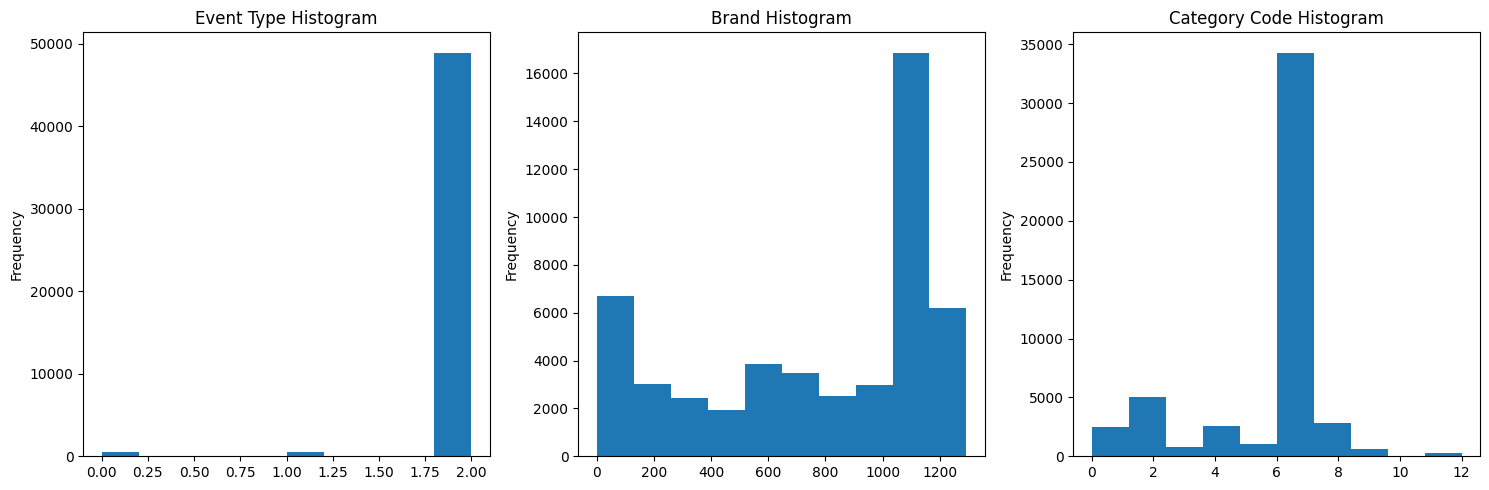

In [38]:
# Create subplots for the histograms
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histograms for 'event_type', 'brand', and 'category_code'
df['event_type'].plot(kind='hist', ax=axes[0], bins=10, title='Event Type Histogram')
df['brand'].plot(kind='hist', ax=axes[1], bins=10, title='Brand Histogram')
df['main_category'].plot(kind='hist', ax=axes[2], bins=10, title='Category Code Histogram')

# Show the histograms
plt.tight_layout()
plt.show()

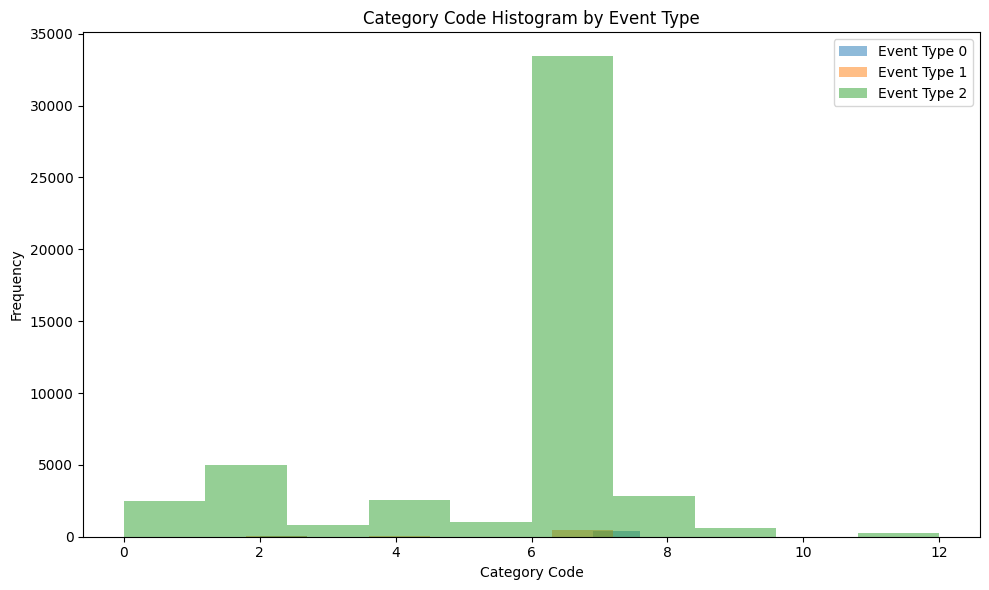

In [39]:
# Group by 'event_type' and create histograms for 'category_code'
fig, ax = plt.subplots(figsize=(10, 6))
for event_type, group in df.groupby('event_type'):
    group['main_category'].plot(kind='hist', ax=ax, alpha=0.5, bins=10, label=f'Event Type {event_type}')

# Add labels and legend
plt.xlabel('Category Code')
plt.ylabel('Frequency')
plt.title('Category Code Histogram by Event Type')
plt.legend()

# Show the histogram
plt.tight_layout()
plt.show()


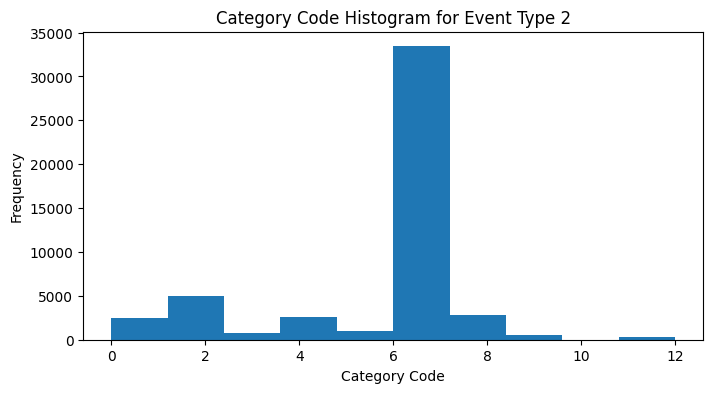

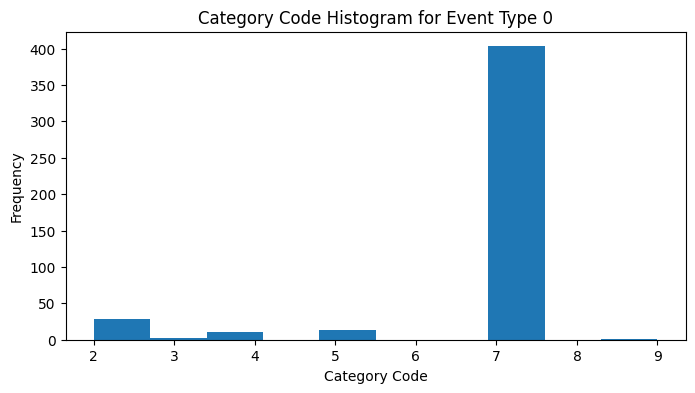

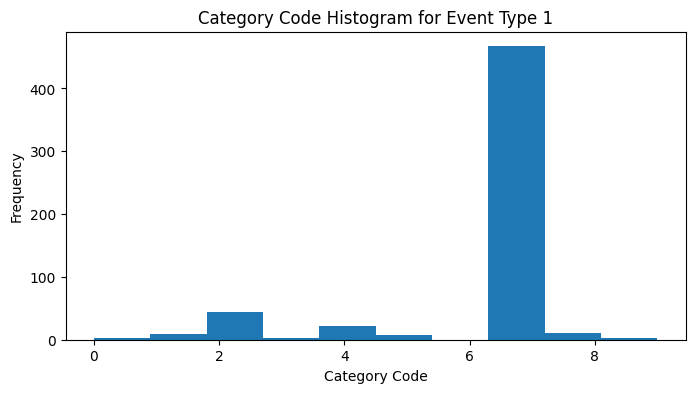

In [40]:
# Get unique event types
unique_event_types = df['event_type'].unique()

# Create a separate histogram for each event type
for event_type in unique_event_types:
    plt.figure(figsize=(8, 4))  # Create a new figure for each event type
    plt.hist(df[df['event_type'] == event_type]['main_category'], bins=10)
    plt.title(f'Category Code Histogram for Event Type {event_type}')
    plt.xlabel('Category Code')
    plt.ylabel('Frequency')

    plt.show()  # Show each individual histogram

### Kmeans

Cluster Centers:
[[1.95488253e+00 2.65233578e+06]
 [1.99391015e+00 3.36748974e+07]
 [1.98547319e+00 1.52672248e+07]]
Inertia (Within-cluster Sum of Squares): 1.0461109670889559e+18

Cluster Centers (Centroids):
[[1.95488253e+00 2.65233578e+06]
 [1.99391015e+00 3.36748974e+07]
 [1.98547319e+00 1.52672248e+07]]

Number of Points in Each Cluster: [27240, 8703, 14043]
Silhouette Score: 0.7063342755672446
Davies-Bouldin Index: 0.4988605696627335


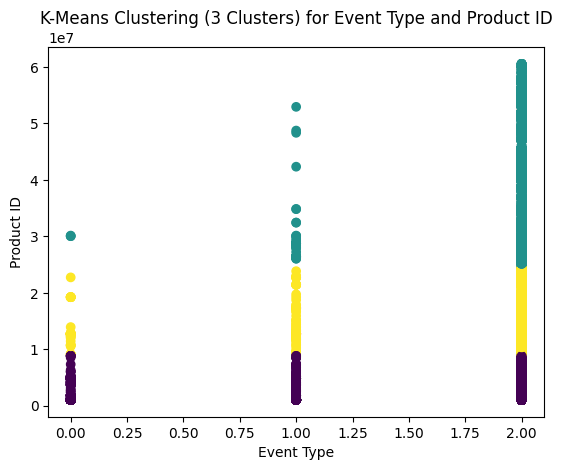

In [41]:
# Select the columns for clustering
X = df[["event_type", "product_id"]]

# Initialize and fit K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Print cluster centers (centroids)
print("Cluster Centers:")
print(kmeans.cluster_centers_)


# Cluster evaluation metrics
inertia = kmeans.inertia_  # Inertia (within-cluster sum of squares)
cluster_centers = kmeans.cluster_centers_  # Cluster centers (centroids)
labels = kmeans.labels_  # Cluster labels
n_points_in_clusters = [sum(labels == i) for i in range(3)]  # Number of points in each cluster
silhouette_avg = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)

# Print cluster evaluation metrics
print("Inertia (Within-cluster Sum of Squares):", inertia)
print("\nCluster Centers (Centroids):")
print(cluster_centers)
print("\nNumber of Points in Each Cluster:", n_points_in_clusters)
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# Visualize the clusters
plt.scatter(df['event_type'], df['product_id'], c=df['cluster'], cmap='viridis')
plt.xlabel("Event Type")
plt.ylabel("Product ID")
plt.title("K-Means Clustering (3 Clusters) for Event Type and Product ID")
plt.show()

Inertia (Within-cluster Sum of Squares): 5653789.5433482705

Cluster Centers (Centroids):
[[ 6.59997106 93.07525326 14.05147557]
 [ 5.29000852 22.43190946 12.49755669]
 [ 4.12674886 65.59038648 16.04255412]]

Number of Points in Each Cluster: [34550, 8217, 7219]
Silhouette Score: 0.6025989015965196
Davies-Bouldin Index: 0.5913361138416215


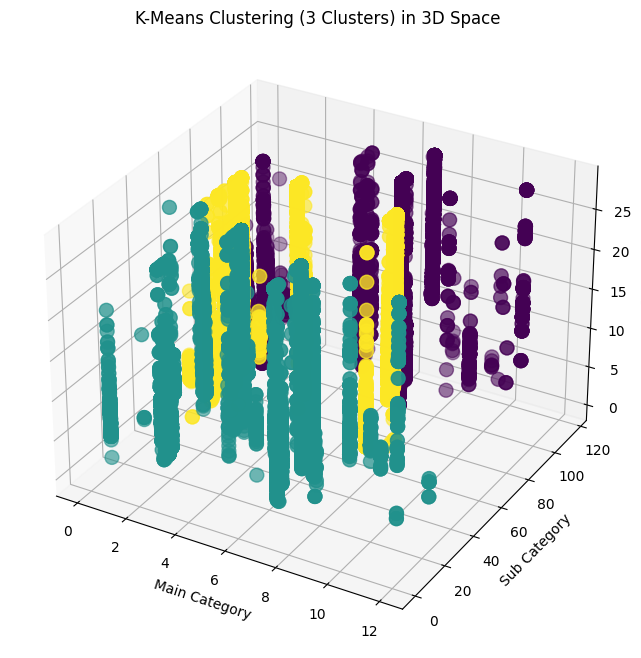

In [42]:
# Initialize K-Means with 3 clusters
# Select the columns for clustering
X = df[["main_category", "sub_category", "price"]]

kmeans = KMeans(n_clusters=3, random_state=42)

df['cluster'] = kmeans.fit_predict(X)


# Cluster evaluation metrics
inertia = kmeans.inertia_  # Inertia (within-cluster sum of squares)
cluster_centers = kmeans.cluster_centers_  # Cluster centers (centroids)
labels = kmeans.labels_  # Cluster labels
n_points_in_clusters = [sum(labels == i) for i in range(3)]  # Number of points in each cluster
silhouette_avg = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)
# Print cluster evaluation metrics
print("Inertia (Within-cluster Sum of Squares):", inertia)
print("\nCluster Centers (Centroids):")
print(cluster_centers)
print("\nNumber of Points in Each Cluster:", n_points_in_clusters)
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['main_category']
y = df['sub_category']
z = df['price']
c = df['cluster']

ax.scatter(x, y, z, c=c, marker='o', cmap='viridis', s=100)

ax.set_xlabel('Main Category')
ax.set_ylabel('Sub Category')
ax.set_zlabel('Price')
ax.set_title('K-Means Clustering (3 Clusters) in 3D Space')

plt.show()


### DBSCAN

Silhouette Score: 0.7330732119557719
Davies-Bouldin Index: 3.298823977212006


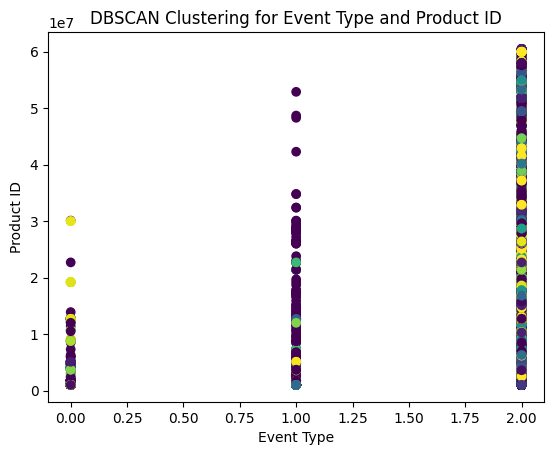

In [43]:
# Select the columns for clustering
X = df[["event_type", "product_id"]]
# Initialize DBSCAN with specified parameters
dbscan = DBSCAN(eps=0.01, min_samples=2)

# Fit the model and get cluster labels (-1 indicates noise)
df['cluster'] = dbscan.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# Visualize the clusters
plt.scatter(df['event_type'], df['product_id'], c=df['cluster'], cmap='viridis')
plt.xlabel("Event Type")
plt.ylabel("Product ID")
plt.title("DBSCAN Clustering for Event Type and Product ID")
plt.show()

Silhouette Score: -0.3074706835415965
Davies-Bouldin Index: 1.7167475174253306


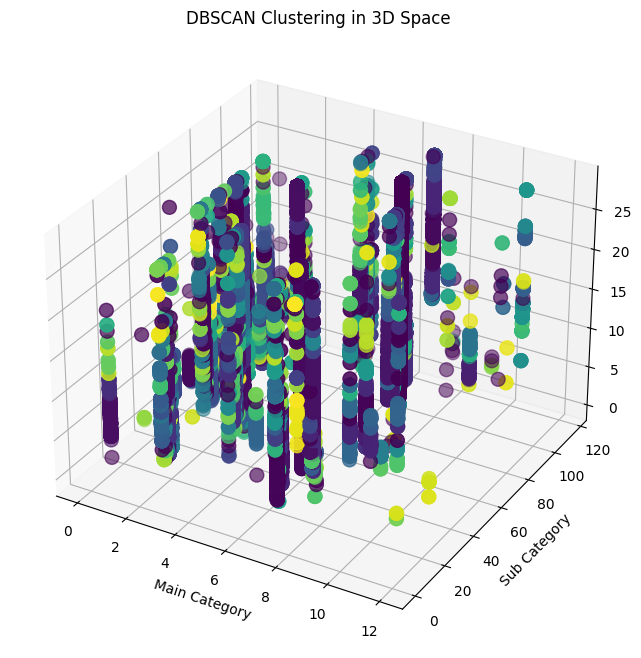

In [44]:
# Select the columns for clustering
X = df[["main_category", "sub_category", "price"]]
# Initialize DBSCAN with specified parameters
dbscan = DBSCAN(eps=0.5, min_samples=2)
# Fit the model and get cluster labels (-1 indicates noise)
df['cluster'] = dbscan.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['main_category']
y = df['sub_category']
z = df['price']
c = df['cluster']

ax.scatter(x, y, z, c=c, marker='o', cmap='viridis', s=100)

ax.set_xlabel('Main Category')
ax.set_ylabel('Sub Category')
ax.set_zlabel('Price')
ax.set_title('DBSCAN Clustering in 3D Space')

plt.show()

### Spectral Clustering

In [45]:
#spectral clustering
X = df[["event_type", "product_id"]]

# Initialize Spectral Clustering with specified parameters
spectral = SpectralClustering(n_clusters=3, affinity='rbf', random_state=42)

# Fit the model and get cluster labels
df['cluster'] = spectral.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# Visualize the clusters
plt.scatter(df['event_type'], df['product_id'], c=df['cluster'], cmap='viridis')
plt.xlabel("Event Type")
plt.ylabel("Product ID")
plt.title("Spectral Clustering (3 Clusters) for Event Type and Product ID")
plt.show() 

MemoryError: Unable to allocate 18.6 GiB for an array with shape (49986, 49986) and data type float64

In [46]:
# Select the columns for clustering
X = df[["main_category", "sub_category", "price"]]

# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=3, affinity='rbf', random_state=42)

# Fit the model and get cluster labels
df['cluster'] = spectral_clustering.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['main_category']
y = df['sub_category']
z = df['price']
c = df['cluster']

ax.scatter(x, y, z, c=c, marker='o', cmap='viridis', s=100)

ax.set_xlabel('Main Category')
ax.set_ylabel('Sub Category')
ax.set_zlabel('Price')
ax.set_title('Spectral Clustering in 3D Space')

plt.show()

MemoryError: Unable to allocate 18.6 GiB for an array with shape (49986, 49986) and data type float64

### Gaussian Mixture Clustering

Silhouette Score: 0.3925972706683751
Davies-Bouldin Index: 1.665089558679961


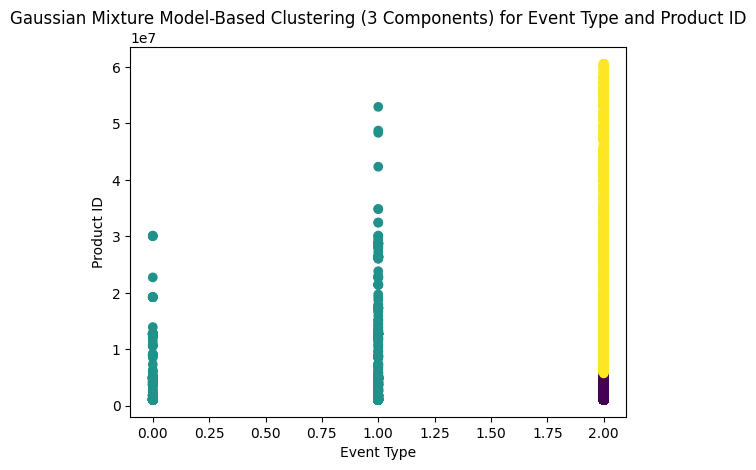

In [45]:
#gaussian mixture model
X = df[["event_type", "product_id"]]

# Initialize Gaussian Mixture Model with specified parameters
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

# Fit the model and get cluster labels
df['cluster'] = gmm.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# Visualize the clusters
plt.scatter(df['event_type'], df['product_id'], c=df['cluster'], cmap='viridis')
plt.xlabel("Event Type")
plt.ylabel("Product ID")
plt.title("Gaussian Mixture Model-Based Clustering (3 Components) for Event Type and Product ID")
plt.show()

Silhouette Score: 0.35269943388106584
Davies-Bouldin Index: 1.9985618588431668


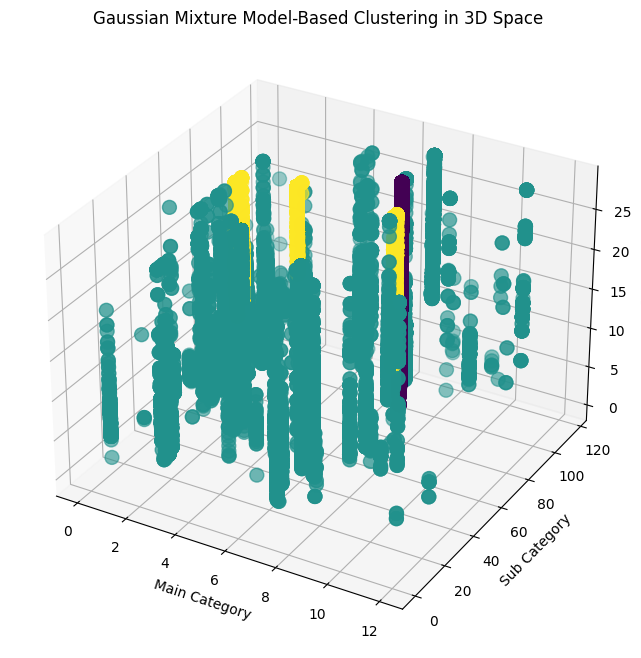

In [46]:
# Select the columns for clustering
X = df[["main_category", "sub_category", "price"]]
# Initialize Gaussian Mixture Model with specified parameters
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

# Fit the model and get cluster labels
df['cluster'] = gmm.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['main_category']
y = df['sub_category']
z = df['price']
c = df['cluster']

ax.scatter(x, y, z, c=c, marker='o', cmap='viridis', s=100)

ax.set_xlabel('Main Category')
ax.set_ylabel('Sub Category')
ax.set_zlabel('Price')
ax.set_title('Gaussian Mixture Model-Based Clustering in 3D Space')

plt.show()

### Agglomerative Clustering: 

In [ ]:
# Select the columns for clustering
X = df[["event_type", "product_id"]]
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)

# Fit the model and get cluster labels
df['agg_cluster'] = agg_clustering.fit_predict(X)

# Calculate Silhouette Scores and Davies-Bouldin Index for Agglomerative Clustering
agg_silhouette_avg = silhouette_score(X, df['agg_cluster'])
agg_db_index = davies_bouldin_score(X, df['agg_cluster'])

# Print cluster evaluation metrics for Agglomerative Clustering
print("Agglomerative Clustering:")
print("Silhouette Score:", agg_silhouette_avg)
print("Davies-Bouldin Index:", agg_db_index)

# Visualize the Agglomerative Clustering clusters
plt.scatter(df['event_type'], df['product_id'], c=df['agg_cluster'], cmap='viridis')
plt.xlabel("Event Type")
plt.ylabel("Product ID")
plt.title("Agglomerative Clustering (3 Clusters) for Event Type and Product ID")
plt.show()

In [ ]:
# Select the columns for clustering
X = df[["main_category", "sub_category", "price"]]
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)

# Fit the model and get cluster labels
df['cluster'] = agg_clustering.fit_predict(X)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, df['cluster'])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['main_category']
y = df['sub_category']
z = df['price']
c = df['cluster']

ax.scatter(x, y, z, c=c, marker='o', cmap='viridis', s=100)

ax.set_xlabel('Main Category')
ax.set_ylabel('Sub Category')
ax.set_zlabel('Price')
ax.set_title('Agglomerative Clustering in 3D Space')

plt.show()




### Deep Kmeans

1563/1563 [==============================] - 3s 2ms/step
Silhouette Score: 0.598522174555053
Davies-Bouldin Index: 0.5903659796109432


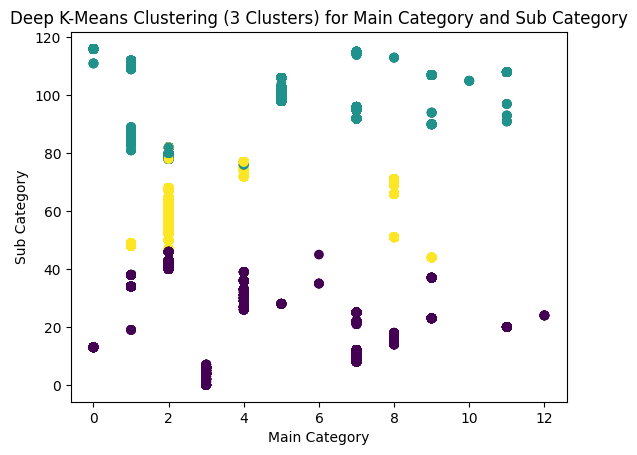

In [47]:
import tensorflow as tf
from tensorflow import keras



X = df[["main_category", "sub_category", "price"]]


# Define the deep autoencoder model for feature learning
input_layer = keras.layers.Input(shape=(3,))
encoder = keras.layers.Dense(64, activation='relu')(input_layer)
encoder = keras.layers.Dense(32, activation='relu')(encoder)
encoder = keras.layers.Dense(16, activation='relu')(encoder)
encoder_output = keras.layers.Dense(8, activation='relu')(encoder)

decoder = keras.layers.Dense(16, activation='relu')(encoder_output)
decoder = keras.layers.Dense(32, activation='relu')(decoder)
decoder = keras.layers.Dense(64, activation='relu')(decoder)
decoder_output = keras.layers.Dense(3, activation='linear')(decoder)

autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X, X, epochs=100, batch_size=32, verbose=0)

# Extract the learned features from the encoder
encoder_model = keras.models.Model(inputs=input_layer, outputs=encoder_output)
encoded_features = encoder_model.predict(X)

# Apply K-Means clustering on the learned features
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(encoded_features)

# Calculate Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(X, df['cluster'])
db_index = davies_bouldin_score(X, df['cluster'])

# Print cluster evaluation metrics
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)

# Visualize the clusters
plt.scatter(df['main_category'], df['sub_category'], c=df['cluster'], cmap='viridis')
plt.xlabel("Main Category")
plt.ylabel("Sub Category")
plt.title("Deep K-Means Clustering (3 Clusters) for Main Category and Sub Category")
plt.show()
